In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
from insightface.app import FaceAnalysis
import matplotlib.pyplot as plt

/Users/samir/miniforge3/envs/kinship_recognition/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.18 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:

# Initialize FaceAnalysis
app = FaceAnalysis(name='buffalo_l')
app.prepare(ctx_id=0, det_size=(128, 128))

/Users/samir/miniforge3/envs/kinship_recognition/lib/python3.10/site-packages/onnxruntime/capi/onnxruntime_inference_collection.py:69: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'CoreMLExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /Users/samir/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /Users/samir/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /Users/samir/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /Users/samir/.insightface/models/buffalo_l/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /Users/samir/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
se

In [3]:

# Define paths
INPUT_ROOT = '../data/processed/fiw/train/train-faces'
METADATA_CSV = '../data/processed/fiw/train/fiw_metadata.csv'

# Load metadata
metadata_df = pd.read_csv(METADATA_CSV)


In [4]:
def get_face_embedding(image_path):
    img = cv2.imread(image_path)
    faces = app.get(img)
    if faces:
        return faces[0].embedding
    return None

def process_individual(family, member, image_paths):
    embeddings = []
    valid_paths = []
    for path in image_paths:
        embedding = get_face_embedding(path)
        if embedding is not None:
            embeddings.append(embedding)
            valid_paths.append(path)
    
    if len(embeddings) < 2:
        return [], [], []  # Not enough images to compare
    
    similarity_matrix = cosine_similarity(embeddings)
    avg_similarities = similarity_matrix.mean(axis=1)
    
    # Adaptive thresholding
    threshold = max(np.mean(avg_similarities) - np.std(avg_similarities), 0.5)
    
    # Keep images with similarity above threshold
    keep_indices = np.where(avg_similarities >= threshold)[0]
    remove_indices = np.where(avg_similarities < threshold)[0]
    
    kept_paths = [valid_paths[i] for i in keep_indices]
    removed_paths = [valid_paths[i] for i in remove_indices]
    
    return kept_paths, removed_paths, avg_similarities


In [5]:
import pickle
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Process each individual
results = []
for family in tqdm(os.listdir(INPUT_ROOT)):
    family_path = os.path.join(INPUT_ROOT, family)
    for member in os.listdir(family_path):
        if member == 'unrelated_and_nonfaces':
            continue
        
        member_path = os.path.join(family_path, member)
        image_paths = [os.path.join(member_path, img) for img in os.listdir(member_path) if img.endswith(('.jpg', '.png', '.jpeg'))]
        
        total_images = len(image_paths)
        
        # Skip individuals with fewer than 2 images
        if total_images < 2:
            continue

        kept_images, removed_images, similarities = process_individual(family, member, image_paths)
        
        results.append({
            'Family': family,
            'Member': member,
            'Total_Images': total_images,
            'Kept_Images': kept_images,
            'Removed_Images': removed_images,
            'Similarities': similarities,
            'Avg_Similarity': np.mean(similarities)
        })

# Save results to a file
with open('../data/processed/fiw/train/image_quality_results.pkl', 'wb') as f:
    pickle.dump(results, f)

# Create a DataFrame with the summary results
results_df = pd.DataFrame([{k: v for k, v in r.items() if k not in ['Kept_Images', 'Removed_Images', 'Similarities']} for r in results])
print(results_df.describe())

# Save summary results to CSV
results_df.to_csv('../data/processed/fiw/train/image_quality_summary.csv', index=False)

# Update metadata
all_kept_images = [path for result in results for path in result['Kept_Images']]
metadata_df['Is_Kept'] = metadata_df['Aligned_Image_Path'].isin(all_kept_images)

# Save updated metadata
metadata_df.to_csv('../data/processed/fiw/train/fiw_metadata_filtered.csv', index=False)

print("Image quality check completed.")

100%|██████████| 571/571 [26:07<00:00,  2.75s/it]  

       Total_Images  Avg_Similarity
count   2463.000000     2463.000000
mean       6.198944        0.645747
std        5.324656        0.120360
min        2.000000        0.253764
25%        3.000000        0.566848
50%        5.000000        0.654076
75%        8.000000        0.729123
max      109.000000        0.961899
Image quality check completed.


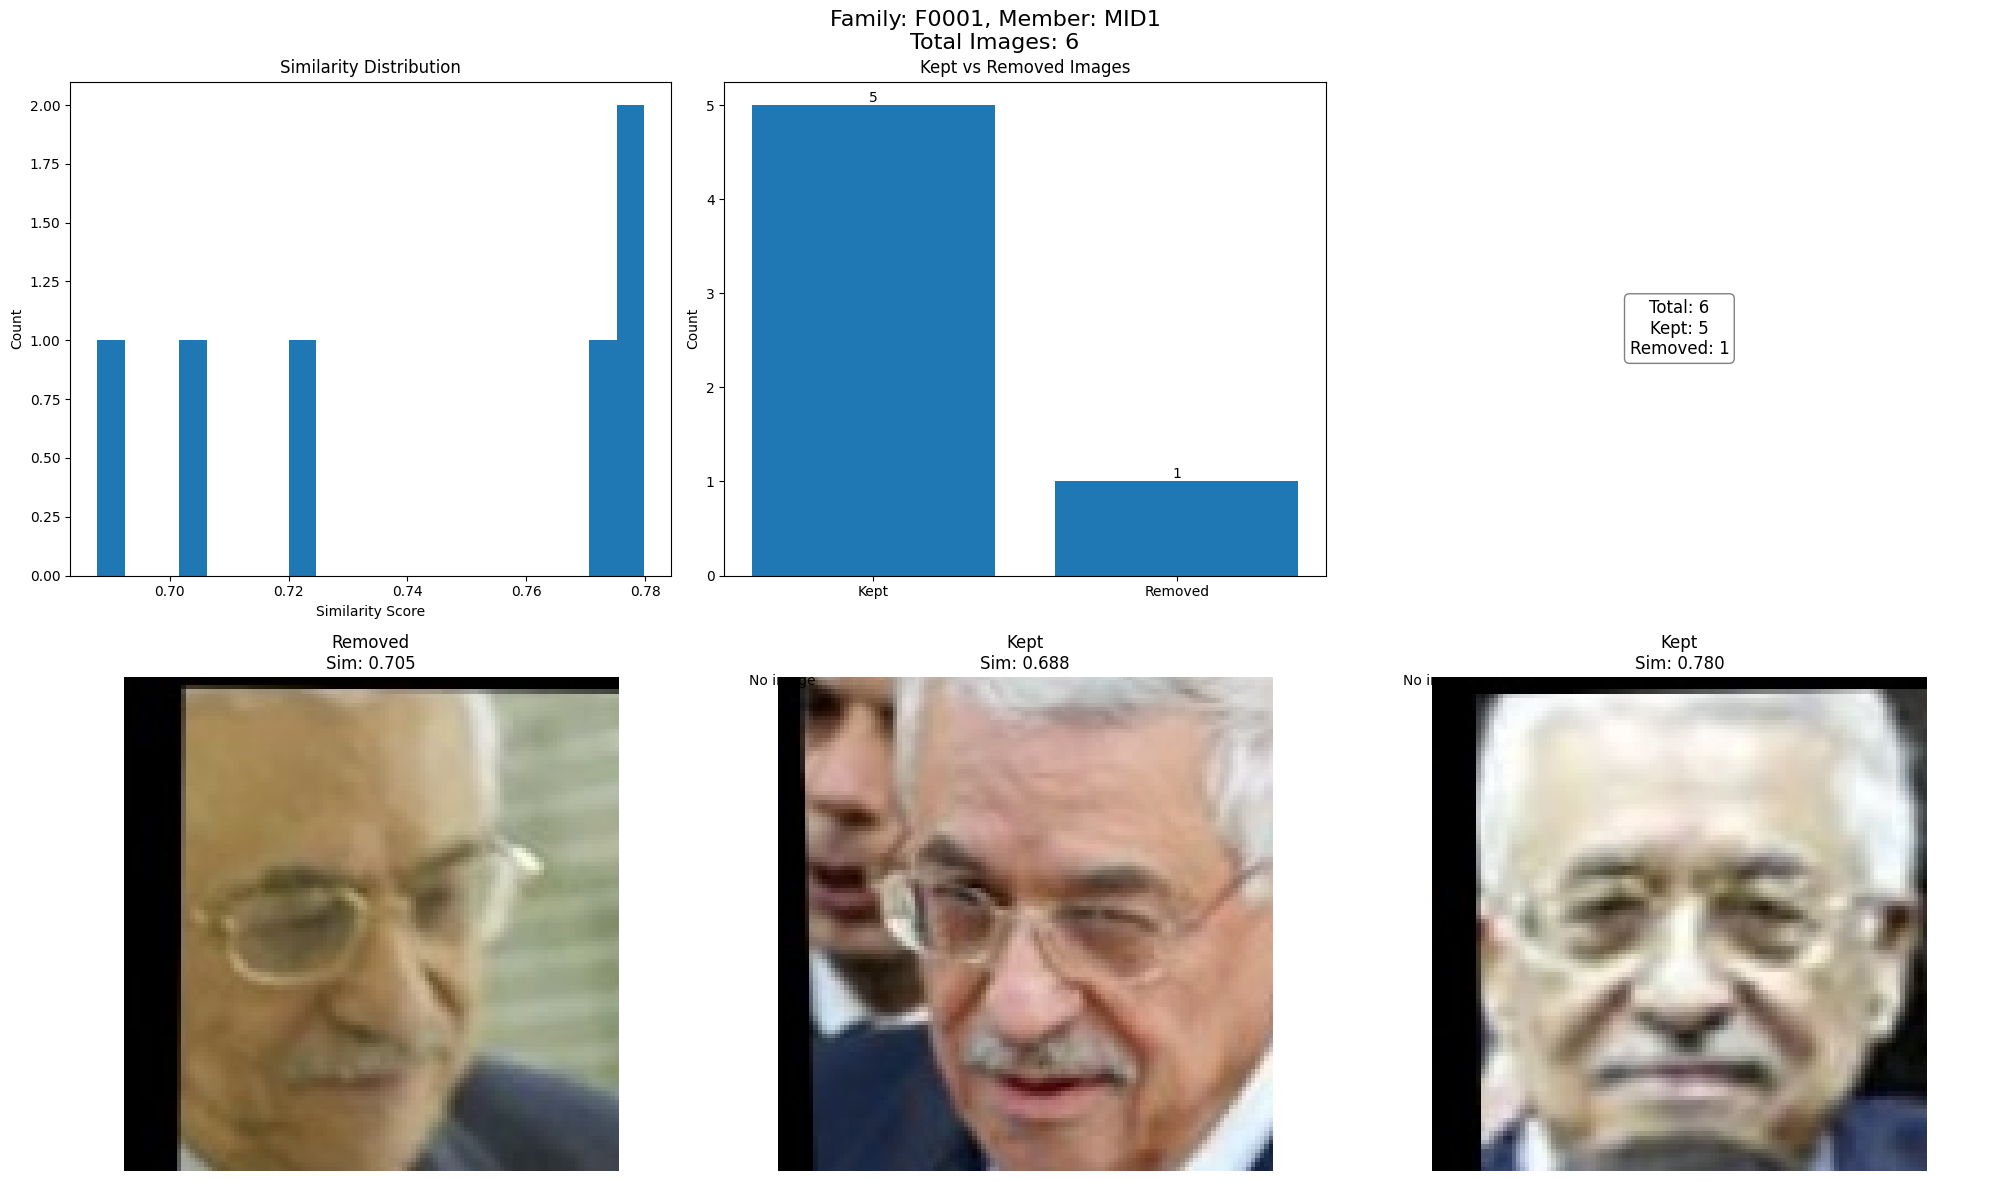

In [5]:
import pickle
import matplotlib.pyplot as plt
import cv2

def visualize_results(kept, removed, family, member, similarities, total_images):
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    fig.suptitle(f"Family: {family}, Member: {member}\nTotal Images: {total_images}", fontsize=16)
    
    # Plot similarity distribution
    axes[0, 0].hist(similarities, bins=20)
    axes[0, 0].set_title("Similarity Distribution")
    axes[0, 0].set_xlabel("Similarity Score")
    axes[0, 0].set_ylabel("Count")
    
    # Plot kept vs removed
    kept_count = len(kept)
    removed_count = len(removed)
    axes[0, 1].bar(['Kept', 'Removed'], [kept_count, removed_count])
    axes[0, 1].set_title("Kept vs Removed Images")
    axes[0, 1].set_ylabel("Count")
    for i, v in enumerate([kept_count, removed_count]):
        axes[0, 1].text(i, v, str(v), ha='center', va='bottom')
    
    # Add text box with summary
    summary_text = f"Total: {total_images}\nKept: {kept_count}\nRemoved: {removed_count}"
    axes[0, 2].text(0.5, 0.5, summary_text, ha='center', va='center', fontsize=12, 
                    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", lw=1))
    axes[0, 2].axis('off')
    
    # Plot sample images
    for i, (images, row, label) in enumerate(zip([kept, removed], [1, 1], ['Kept', 'Removed'])):
        for j in range(3):
            if j < len(images):
                img = cv2.imread(images[j])
                if img is not None:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    axes[row, j].imshow(img)
                    sim_score = similarities[j] if label == 'Kept' else similarities[len(kept) + j]
                    axes[row, j].set_title(f"{label}\nSim: {sim_score:.3f}")
                else:
                    axes[row, j].text(0.5, 0.5, "Image\nread error", ha='center', va='center')
            else:
                axes[row, j].text(0.5, 0.5, "No image", ha='center', va='center')
            axes[row, j].axis('off')
    
    plt.tight_layout()
    plt.show()

def visualize_family_member_results(family, member):
    # Load results
    with open('../data/processed/fiw/train/image_quality_results.pkl', 'rb') as f:
        all_results = pickle.load(f)
    
    # Find the specific result
    result = next((r for r in all_results if r['Family'] == family and r['Member'] == member), None)
    
    if result is None:
        print(f"No results found for Family: {family}, Member: {member}")
        return
    
    # Visualize the result
    visualize_results(result['Kept_Images'], result['Removed_Images'], 
                      family, member, result['Similarities'], result['Total_Images'])

# Example usage:
visualize_family_member_results('F0001', 'MID1')

In [7]:
def list_families_and_members():
    with open('../data/processed/fiw/train/image_quality_results.pkl', 'rb') as f:
        all_results = pickle.load(f)
    
    families = sorted(set(r['Family'] for r in all_results))
    for family in families:
        members = sorted(set(r['Member'] for r in all_results if r['Family'] == family))
        print(f"Family {family}: {', '.join(members)}")

# Example usage:
# list_families_and_members()

In [11]:
# check number of false in fiw_metadata_filtered.csv
df_count = pd.read_csv('../data/processed/fiw/train/fiw_metadata_filtered.csv')

print(df_count['Is_Kept'].value_counts())

Is_Kept
True     10780
False     9562
Name: count, dtype: int64
